# Model Shapping

In [1]:
# Importing the libraries
import os
import pandas as pd

## Load data

In [2]:
# Load and preprocess the train data 
from pipelines import pipeline

data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'train.csv')
train_data = pd.read_csv(data_file, index_col=0, low_memory=False)
train_data = pipeline.fit_transform(train_data)

X = train_data.drop(columns=['bg+1:00'])
y = train_data['bg+1:00']

## Train model with the whole dataset

In [3]:
from src.features.tuners import XGBHyperparameterTuner
from sklearn.metrics import root_mean_squared_error

tuner = XGBHyperparameterTuner()
model = tuner.regressor()
model.fit(X=X, y=y)

root_mean_squared_error(y_true=y, y_pred=model.predict(X=X))

np.float64(1.6485457035030124)

In [4]:
top_feature_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values(ascending=False)
top_feature_importances

bg-0:00                   0.453462
day_phase_night           0.034901
bg-0:15                   0.033341
insulin-0:45              0.016729
insulin-0:30              0.015063
insulin-1:00              0.014728
day_phase_late_evening    0.013870
insulin-0:15              0.013849
day_phase_morning         0.013686
day_phase_evening         0.012742
day_phase_noon            0.012685
insulin-0:00              0.012612
bg-0:30                   0.011613
bg-1:15                   0.011149
bg-0:45                   0.010834
bg-2:15                   0.010664
insulin-1:15              0.010626
insulin-1:30              0.010219
insulin-5:45              0.010163
bg-1:00                   0.009413
insulin-3:45              0.009384
bg-1:45                   0.009356
bg-3:30                   0.009331
insulin-5:15              0.009315
insulin-5:30              0.009150
insulin-2:00              0.009083
insulin-1:45              0.008976
insulin-5:00              0.008956
bg-1:30             

In [5]:
from sklearn.model_selection import KFold, GroupKFold
from tqdm.notebook import tqdm
import numpy as np

rmse_on_feature_length = {}
for i in tqdm(range(1, len(top_feature_importances)+1)):
    X_new = X[top_feature_importances.index[:i]]
    model = tuner.regressor()

    kf = GroupKFold(n_splits=5, shuffle=True, random_state=42)
    # Perform cross-validation
    results = []
    for train_index, test_index in kf.split(X_new, y):
        X_train, X_test = X_new.iloc[train_index], X_new.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        results.append(root_mean_squared_error(y_test, y_pred))

    # Report the mean accuracy across folds
    rmse_on_feature_length[i] = np.mean(results)

  0%|          | 0/53 [00:00<?, ?it/s]

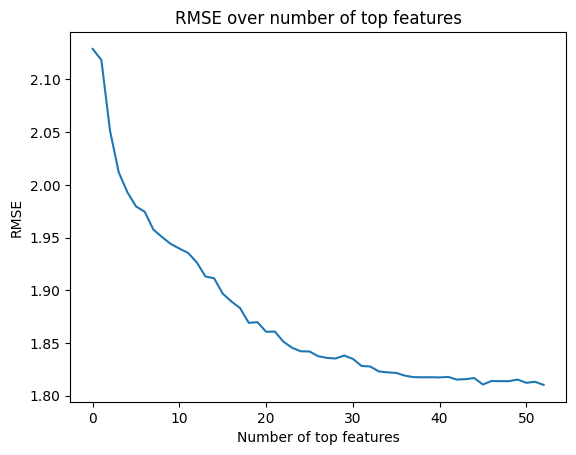

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(rmse_on_feature_length.values())
plt.title('RMSE over number of top features')
plt.xlabel('Number of top features')
plt.ylabel('RMSE')
plt.show()

In [7]:
# Find the key with the minimum value
min_key = min(rmse_on_feature_length, key=rmse_on_feature_length.get)

print("Index with the minimum value:", min_key)
print("Minimum value:", rmse_on_feature_length[min_key])

Index with the minimum value: 53
Minimum value: 1.810204911335314
